# Preprocessing

D:/ Data_Large  contains 1000 meshes, 0.3d-format, and solver_times.csv 
D:/ Data_Large2  contains 1000 meshes, 0.4d -format,  and solver_times.csv 

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import meshio

from sklearn.decomposition import PCA
import seaborn as sns

In [57]:
df = pd.read_csv("D:/ML4pmg/Data_Large2/solver_times.csv") # Data_Large, or Data_Large2
df.head()

,Mesh #,Fractures #,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s),Solver Label,Adjusted Time (s)
0,0,53,0,gmres,ilu,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + ilu + ilu,4.221818
1,0,53,1,gmres,sor,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + sor + ilu,4.221818
2,0,53,2,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + jacobi + ilu,4.221818
3,0,53,3,gmres,bjacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + bjacobi + ilu,4.221818
4,0,53,4,gmres,asm,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + asm + ilu,4.221818


In [58]:
M = len(df['Solver Label'].unique()) # number of unique solvers

for i in range(M):
    ratio = df[df['Combination #'] == i]['Converged'].mean()
    print(f"Solver {i:02d}: Convergence rate = {ratio:.2f}")


# Count how many converged/failed for each solver label
summary = df.groupby(["Combination #", "Converged"]).size().unstack(fill_value=0)

# Optional: rename columns for clarity
summary.columns = ["Failed", "Converged"] if False in summary.columns else summary.columns



Solver 00: Convergence rate = 0.00
Solver 01: Convergence rate = 0.00
Solver 02: Convergence rate = 0.00
Solver 03: Convergence rate = 0.00
Solver 04: Convergence rate = 0.00
Solver 05: Convergence rate = 0.15
Solver 06: Convergence rate = 0.44
Solver 07: Convergence rate = 0.00
Solver 08: Convergence rate = 0.00
Solver 09: Convergence rate = 0.44
Solver 10: Convergence rate = 0.44
Solver 11: Convergence rate = 0.55
Solver 12: Convergence rate = 0.08
Solver 13: Convergence rate = 0.00
Solver 14: Convergence rate = 0.00
Solver 15: Convergence rate = 0.08
Solver 16: Convergence rate = 0.08
Solver 17: Convergence rate = 0.52


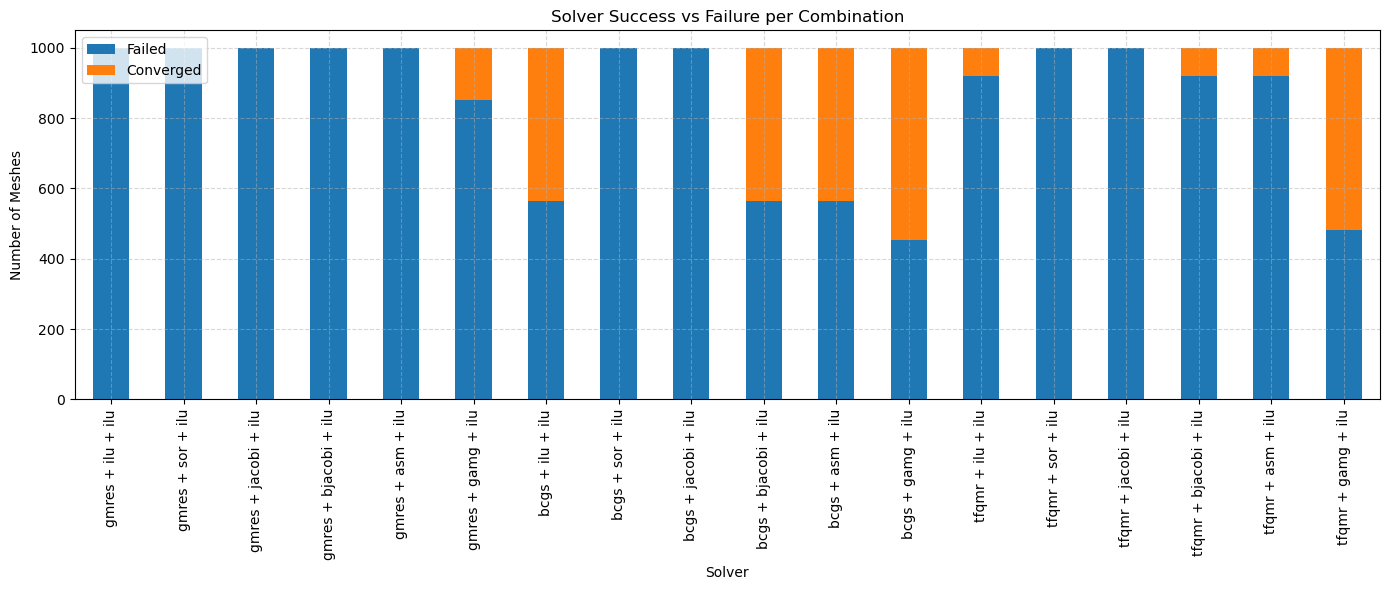

In [59]:
# Plot
summary.plot(kind="bar", stacked=True, figsize=(14, 6))
plt.xlabel("Solver Combination")
plt.ylabel("Number of Meshes")
plt.title("Solver Success vs Failure per Combination")
indices = np.arange(M)
plt.xticks(indices, df["Solver Label"][0:M], rotation=90)
plt.xlabel("Solver")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
# For each mesh, build its 21-d convergence vector
pivot = df.pivot_table(
    index='Mesh #',
    columns='Combination #',
    values='Converged'
).sort_index()

# Convert to integers (0/1), then strings for hashing
vectors = pivot.astype(int).astype(str).agg(''.join, axis=1)

# Count unique convergence patterns
unique_patterns = vectors.nunique()
print(f"Unique convergence patterns: {unique_patterns} / {len(pivot)} total meshes")


Unique convergence patterns: 14 / 1000 total meshes


Unique convergence patterns: 14 / 1000 total meshes



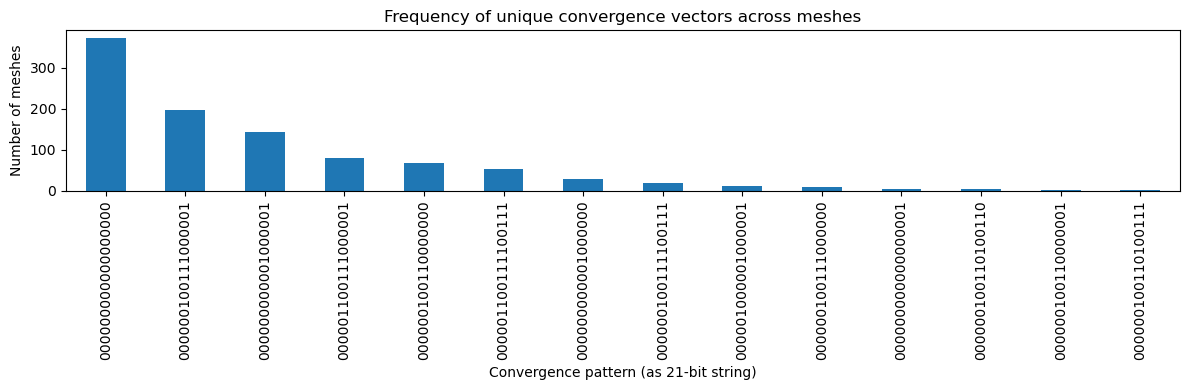

000000000000000000    372
000000100111000001    197
000000000001000001    143
000001100111000001     81
000000100110000000     67
000001100111100111     54
000000000001000000     30
000000100111100111     20
000001000001000001     13
000000100111000000      9
000000000000000001      5
000000100110100110      4
000000100110000001      3
000000100110100111      2
Name: count, dtype: int64


In [61]:

# Count how many times each unique pattern appears
pattern_counts = vectors.value_counts()

# Show summary
print(f"Unique convergence patterns: {len(pattern_counts)} / {len(pivot)} total meshes\n")



plt.figure(figsize=(12, 4))
pattern_counts.plot(kind='bar')
plt.ylabel("Number of meshes")
plt.xlabel("Convergence pattern (as 21-bit string)")
plt.title("Frequency of unique convergence vectors across meshes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


print(pattern_counts)

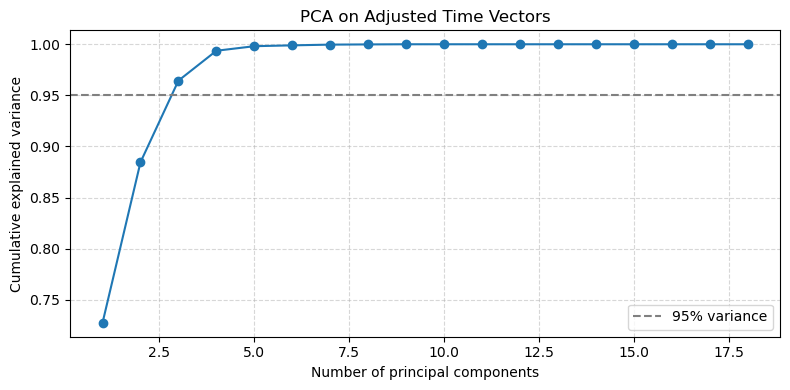

In [62]:

# Pivot adjusted times: rows = mesh IDs, cols = solver combination #
adjusted_pivot = df.pivot_table(
    index='Mesh #',
    columns='Combination #',
    values='Adjusted Time (s)'
).sort_index()

adjusted_log = adjusted_pivot.applymap(lambda x: -np.log(abs(x) + 1e-6))

# Run PCA
pca = PCA()
components = pca.fit_transform(adjusted_log)

# Explained variance
explained = pca.explained_variance_ratio_
cumulative = explained.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative) + 1), cumulative, marker='o')
plt.axhline(0.95, color='gray', linestyle='--', label='95% variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA on Adjusted Time Vectors')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


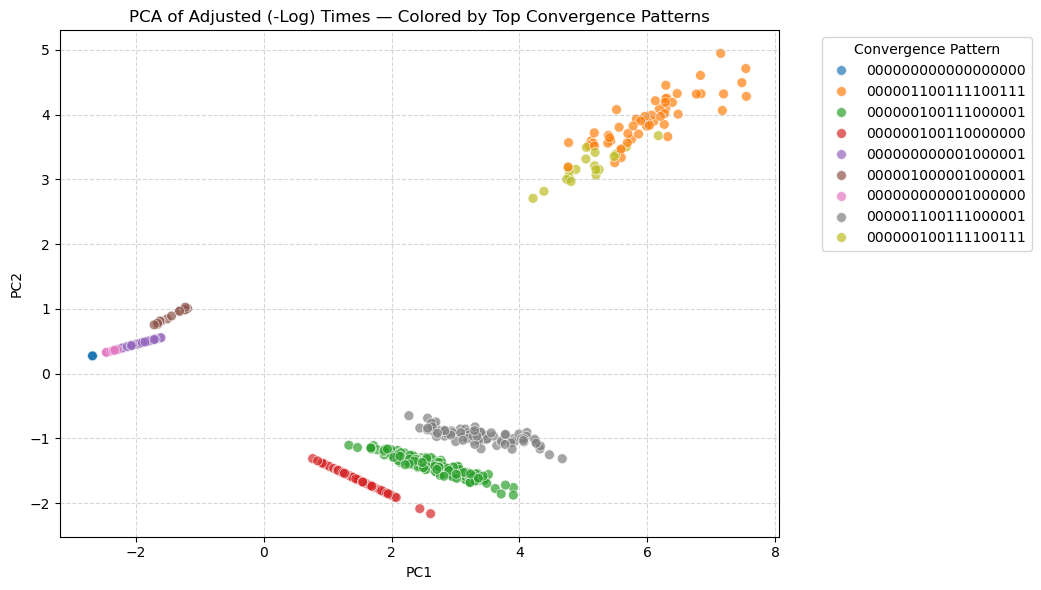

In [63]:

pca_df = pd.DataFrame(components[:, :2], columns=['PC1', 'PC2'])
pca_df['pattern'] = vectors.values

# Plot with color per pattern (most frequent first)
top_patterns = vectors.value_counts().index[:9]  # show only top 9 for clarity
filtered = pca_df[pca_df['pattern'].isin(top_patterns)]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=filtered,
    x='PC1', y='PC2',
    hue='pattern',
    palette='tab10',
    s=50,
    alpha=0.7
)
plt.title("PCA of Adjusted (-Log) Times — Colored by Top Convergence Patterns")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(title="Convergence Pattern", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


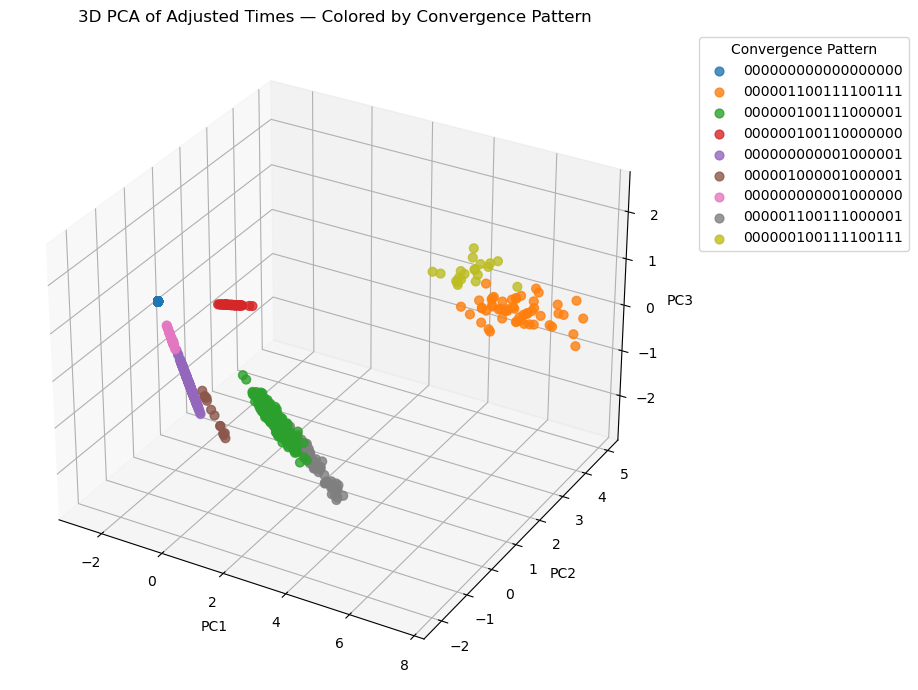

In [64]:
from mpl_toolkits.mplot3d import Axes3D  


pca_df = pd.DataFrame(components[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['pattern'] = vectors.values

# Filter top 11 patterns
top_patterns = vectors.value_counts().index[:9]
filtered = pca_df[pca_df['pattern'].isin(top_patterns)]

# Plot in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assign unique colors to each pattern
patterns = filtered['pattern'].unique()
colors = plt.cm.tab10.colors  # max 10, loop if needed

for i, pattern in enumerate(patterns):
    subset = filtered[filtered['pattern'] == pattern]
    ax.scatter(
        subset['PC1'], subset['PC2'], subset['PC3'],
        label=pattern,
        s=40,
        alpha=0.8,
        color=colors[i % len(colors)]
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA of Adjusted Times — Colored by Convergence Pattern")
ax.legend(title="Convergence Pattern", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [66]:
pca_df

,PC1,PC2,PC3,pattern
0,-2.684108,0.275832,0.445111,000000000000000000
1,-2.684108,0.275832,0.445111,000000000000000000
2,5.123805,3.597293,0.209539,000001100111100111
3,-2.684108,0.275832,0.445111,000000000000000000
4,-2.684108,0.275832,0.445111,000000000000000000
...,...,...,...,...
995,-2.684108,0.275832,0.445111,000000000000000000
996,-1.719170,0.527608,-1.707426,000000000001000001
997,1.548192,-1.672787,2.063550,000000100110000000
998,1.259789,-1.538042,1.955751,000000100110000000


In [67]:
# Count occurrences of each pattern
pattern_counts = pca_df['pattern'].value_counts()

# Create mapping: most frequent pattern → 0, next → 1, etc.
pattern_to_id = {pattern: idx for idx, pattern in enumerate(pattern_counts.index)}

# Map patterns to Pattern ID
pca_df['Pattern ID'] = pca_df['pattern'].map(pattern_to_id)

# Make sure Mesh # is the index or a column
pca_df['Mesh #'] = pca_df.index


In [68]:
pca_df


,PC1,PC2,PC3,pattern,Pattern ID,Mesh #
0,-2.684108,0.275832,0.445111,000000000000000000,0,0
1,-2.684108,0.275832,0.445111,000000000000000000,0,1
2,5.123805,3.597293,0.209539,000001100111100111,5,2
3,-2.684108,0.275832,0.445111,000000000000000000,0,3
4,-2.684108,0.275832,0.445111,000000000000000000,0,4
...,...,...,...,...,...,...
995,-2.684108,0.275832,0.445111,000000000000000000,0,995
996,-1.719170,0.527608,-1.707426,000000000001000001,2,996
997,1.548192,-1.672787,2.063550,000000100110000000,4,997
998,1.259789,-1.538042,1.955751,000000100110000000,4,998


In [ ]:
#df.drop(columns=['Patterns'], inplace=True) # to delete a column


In [69]:
top_counts = vectors.value_counts()
N_patterns = 9

def pattern_stat(id, top_counts, df): 
    selected_pattern = top_counts.index[id]  
    pattern_df = df[df["pattern"] == selected_pattern]
    unique_meshes_df = pattern_df.drop_duplicates(subset="Mesh #")
    filtered_df = unique_meshes_df[["Mesh #"]]
    return filtered_df

mdf=pattern_stat(0, top_counts, pca_df)
mdf

,Mesh #
0,0
1,1
3,3
4,4
5,5
...,...
985,985
988,988
992,992
993,993


In [70]:
import random

# Parameters
N_patterns = 9 # number of top patterns to include
k = 50  # number of mesh IDs to select per pattern

balanced_mesh_ids_per_pattern = []  # Final result: list of length m, each entry is list of k mesh IDs

for pattern_id in range(N_patterns):
    # Get filtered mesh IDs for this pattern
    mdf = pattern_stat(pattern_id, top_counts, pca_df)[["Mesh #"]]
    mesh_ids = mdf["Mesh #"].tolist()
    
    if len(mesh_ids) >= k:
        sampled_ids = random.sample(mesh_ids, k)  # select k without replacement
    else:
        sampled_ids = mesh_ids + random.choices(mesh_ids, k=k - len(mesh_ids))  # oversample with replacement
    
    balanced_mesh_ids_per_pattern.append(sampled_ids)


In [71]:
# Just checking the last one...
unique_ids = np.unique(np.array(balanced_mesh_ids_per_pattern[-1]))
print(len(unique_ids))



13


In [72]:
balanced_mesh_ids = [mesh_id for group in balanced_mesh_ids_per_pattern for mesh_id in group]

len(balanced_mesh_ids)
np.savetxt("Data_Large2/balanced_mesh_ids.csv", balanced_mesh_ids, fmt="%d")

In [73]:
len(balanced_mesh_ids)

450

In [74]:
# Filter rows in pca_df where 'Mesh #' is in balanced_mesh_ids
filtered = pca_df[pca_df['Mesh #'].isin(balanced_mesh_ids)]

# Check if all Pattern IDs are between 0 and 8
min_id = filtered['Pattern ID'].min()
max_id = filtered['Pattern ID'].max()

print(f"Pattern ID range in filtered set: {min_id} to {max_id}")


Pattern ID range in filtered set: 0 to 8


In [75]:
filtered['Pattern ID'].unique()

array([0, 5, 1, 8, 6, 4, 2, 7, 3], dtype=int64)

In [76]:
pca_df.to_csv("Data_Large2/pattern_and_pca.csv", index=False)